In [1]:
#-*- coding: utf-8 -*-
from aae_utils import set_gpu_usage,get_train_test,sample_fault,sample_from_prior
from data import data_loader

import keras.backend as K
from keras.layers import Input,Dense,Merge,merge
from keras.layers.core import Activation
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils.generic_utils import Progbar
from collections import defaultdict
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.patches as mpatches
from math import sin,cos,sqrt

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib
matplotlib.pyplot.switch_backend('agg')
from mpl_toolkits.mplot3d import Axes3D
import os
import errno



/home/zhangj/anaconda2/envs/Python35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def set_gpu_usage(ratio=0.9,gpu=1):
    config=tf.ConfigProto(gpu_options=tf.GPUOptions(
                                        per_process_gpu_memory_fraction=ratio,
                                        allow_growth=True),
                          device_count={'GPU':gpu},
                          allow_soft_placement=True)
    sess=tf.Session(config=config)
    K.set_session(sess)


def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
def get_normalized_vector(v):
    v=v/(1e-20+K.max(K.abs(v),axis=1,keepdims=True))
    v_2=K.sum(v**2,axis=1,keepdims=True)
    return v / K.sqrt(1e-6+v_2)

# sample function of z_p

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [3]:
latent_dim = 2
z_prior='gaussian'
lamb=-20
recon_obj_type='QE'
initial_learning_rate=0.003
learning_rate_decay=1.0
num_epochs=20
batch_size=10
save_filename='trained_model'
seed=1
path='./datasets'

opt_gen=Adam(lr=0.00001,decay=0.99)
opt_rec=Adam(lr=0.001,decay=0.99)
opt_disc=Adam(lr=0.02,decay=0.99)

make_sure_path_exists(path)

## Data_preprocess

In [4]:
set_gpu_usage(ratio=0.9,gpu=0)

datapath = os.getcwd() + '/datasets'


# train,x_min,x_max = data_loader(datapath)
# x_train,x_test = get_train_test(train,train_ratio)
DataFiles={'normal':'d00_te.dat','fault1':'d01_te.dat','fault2':'d02_te.dat',
           'fault3':'d03_te.dat','fault4':'d04_te.dat','fault5':'d05_te.dat',
           'fault6':'d06_te.dat','fault7':'d07_te.dat','fault8':'d08_te.dat',
           'fault9':'d09_te.dat','fault10':'d10_te.dat','fault11':'d11_te.dat',
           'fault12':'d12_te.dat','fault13':'d13_te.dat','fault14':'d14_te.dat',
           'fault15':'d15_te.dat','fault16':'d16_te.dat','fault17':'d17_te.dat',
           'fault18':'d18_te.dat','fault19':'d19_te.dat','fault20':'d20_te.dat',
           'fault21':'d21_te.dat'}

datapath = os.getcwd() + '/datasets/data_960'
xx=np.genfromtxt(datapath + '/d00.dat',dtype=np.float32)
yy=np.genfromtxt(datapath + '/d00_te.dat',dtype=np.float32)
fault_1_path = datapath + '/d01_te.dat'
fault = np.genfromtxt(fault_1_path,dtype=None)
fault = fault[160:960]
np.random.seed(0)
np.random.shuffle(fault)
#for j in range(2,22):
    #if j < 10:
        #test_path = datapath + '/d0' + str(j) + '_te.dat'
    #else:  
        #test_path = datapath + '/d' + str(j) + '_te.dat'
    #fault_data = np.genfromtxt(test_path,dtype = 'float32')
    #fault_data = fault_data[160:960]
    #np.random.seed(0)
    #np.random.shuffle(fault_data)
    #fault_data = fault_data[0:10]
    #fault = np.row_stack((fault,fault_data))
x_fault = fault

train_data=np.row_stack((xx.T,yy,x_fault))   #将数据矩阵x和y合成新的数据矩阵用于训练
#np.random.shuffle(train_data)
n=train_data.shape[0]
y=np.zeros((n,1))

for i in range(1,n):
    if i<1460:
        y[i,0]=1
    else:
        y[i,0]=0

data_ratio=1
X_Normal=train_data
train_data_min=np.min(train_data,axis=0)
train_data_max=np.max(train_data,axis=0)
Data_normalization=(train_data-train_data_min)/(train_data_max-train_data_min)
#print(X_Normal.shape[0])
index=np.arange(X_Normal.shape[0])
np.random.shuffle(index)
data_size=int(train_data.shape[0]*data_ratio)
X_normal=X_Normal[index[:data_size]]
Y=y[index[:data_size]]
#print(X_normal.shape[0])
X_min=np.min(X_normal,axis=0)
X_max=np.max(X_normal,axis=0)
#训练集大小
X=X_normal
train_ratio=0.9
X_normalization=(X-X_min)/(X_max-X_min)  
#np.random.shuffle(X_normalization)
indices=np.arange(X.shape[0])
np.random.shuffle(indices)
train_size=int(X.shape[0]*train_ratio)    
x_train=X_normalization[indices[:train_size]]
x_test=X_normalization[indices[train_size:]]
y_train=Y[indices[:train_size]]
y_test=Y[indices[train_size:]]

print('the shape of x_train:')
print(np.shape(x_train))
print('the shape of x_test:')
print(np.shape(x_test))
print('the shape of y_train:')
print(np.shape(x_train))
print('the shape of y_test:')
print(np.shape(x_test))
print(y_train[0:500])

the shape of x_train:
(2034, 52)
the shape of x_test:
(226, 52)
the shape of y_train:
(2034, 52)
the shape of y_test:
(226, 52)
[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [

## Model config

In [5]:
X=Input(shape=[x_train.shape[1]])
cond=Input(shape=[y_train.shape[1]])
inputs=merge([X,cond],mode='concat',concat_axis=1)
h1=Dense(200,activation='relu')(inputs)
h2=Dense(200,activation='relu')(h1)
z=Dense(latent_dim)(h2)
z_cond=merge([z,cond],mode='concat',concat_axis=1)

/home/zhangj/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zhangj/anaconda2/envs/Python35/lib/python3.5/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/zhangj/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  import sys


In [6]:
decoder_hidden1=Dense(200,activation='relu')
decoder_hidden2=Dense(200,activation='relu')
decoder_out=Dense(52,activation='sigmoid')

h_p1=decoder_hidden1(z_cond)
h_p2=decoder_hidden2(h_p1)
outputs=decoder_out(h_p2)

In [7]:
autoencoder=Model([X,cond],outputs)
encoder=Model([X,cond],z)

In [8]:
d_cond=Input(shape=[y_train.shape[1]])
d_z=Input(shape=[latent_dim])
d_inputs=merge([d_z,d_cond],mode='concat',concat_axis=1)
d_h1=decoder_hidden1(d_inputs)
d_h2=decoder_hidden2(d_h1)
d_out=decoder_out(d_h2)
decoder=Model([d_z,d_cond],d_out)

/home/zhangj/anaconda2/envs/Python35/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/zhangj/anaconda2/envs/Python35/lib/python3.5/site-packages/keras/legacy/layers.py:464: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [9]:
def build_discriminator(input,output_dim=2):
    h=Dense(50)(input)
    h=Activation('relu')(h)
    h=Dense(50)(h)
    h=Activation('relu')(h)
    h=Dense(1)(h)
    h=Activation('sigmoid',name='discriminator_output')(h)
    return h


In [10]:
discriminator_hidden1=Dense(50,activation='relu')
discriminator_hidden2=Dense(50,activation='relu')
discriminator_out=Dense(1,activation='sigmoid')

d_p=discriminator_hidden1(z)
labels=discriminator_out(d_p)

In [11]:
input_z=Input(shape=[latent_dim],name='z_input')
#D_cond=Input(shape=[y_train.shape[1]])
#D_inputs=merge([input_z,D_cond],mode='concat',concat_axis=1)
D_h1=discriminator_hidden1(input_z)
D_h2=discriminator_hidden2(D_h1)
D_out=discriminator_out(D_h2)

discriminator=Model(input_z,D_out)
G_out=discriminator(z)
discriminator_x=Model([X,cond],G_out)

## Target Distribution p(z)

In [12]:

def gaussian_mixture(batch_size, n_dim=2, n_labels=2,
                     x_var=0.5, y_var=0.1, label_indices=None):
    # borrow from:
    # https://github.com/nicklhy/AdversarialAutoEncoder/blob/master/data_factory.py#L40
    if n_dim % 2 != 0:
        raise Exception("n_dim must be a multiple of 2.")

    def sample(x, y, label, n_labels):
        shift = 1.4
        if label >= n_labels:
            label =  np.random.randint(0, n_labels)
        r = 2.0 * np.pi / float(n_labels) * float(label)
        new_x = x * cos(r) - y * sin(r)
        new_y = x * sin(r) + y * cos(r)
        new_x += shift * cos(r)
        new_y += shift * sin(r)
        return np.array([new_x, new_y]).reshape((2,))

    x = np.random.normal(0, x_var, (batch_size, n_dim // 2))
    y = np.random.normal(0, y_var, (batch_size, n_dim // 2))
    z = np.empty((batch_size, n_dim), dtype=np.float32)
    for batch in range(batch_size):
        for zi in range(n_dim // 2):
            if label_indices is not None:
                z[batch, zi*2:zi*2+2] = sample(x[batch, zi], y[batch, zi], label_indices[batch], n_labels)
            else:
                z[batch, zi*2:zi*2+2] = sample(x[batch, zi], y[batch, zi], np.random.randint(0, n_labels), n_labels)

    return z


In [13]:
z=gaussian_mixture(20000)

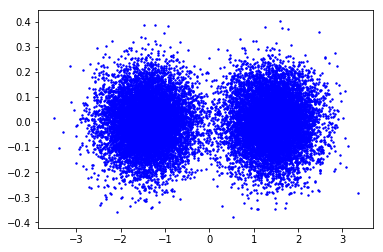

In [14]:
xs, ys = np.array(z).T
plt.figure()
plt.scatter(xs, ys, s=2, color='b')

In [15]:
def reconstruction_loss():        
    if recon_obj_type == 'QE':
        return 'mean_squared_error'
    elif recon_obj_type == 'CE':
        return 'binary_crossentropy'
def rs_loss(y_true,y_pred):
    recon=K.sum(K.binary_crossentropy(y_pred,y_true),axis=1)
    return recon
# build model
autoencoder.compile(optimizer=opt_rec,
                     loss='mean_squared_error')

discriminator.compile(optimizer=opt_disc,
                     loss='binary_crossentropy')

discriminator_x.compile(optimizer=opt_gen,
                     loss='binary_crossentropy')




## Train the model

In [16]:
# In[57]:
nb_batches=int(x_train.shape[0]/batch_size)

# train
train_history = defaultdict(list)
test_history = defaultdict(list)

with open(path+'/train.log','w') as f:
    f.write('train_begin\n' )
    
for epoch in range(num_epochs):
    print('Epoch {} of {}'.format(epoch+1,num_epochs))
    progress_bar=Progbar(target=nb_batches)

    epoch_gen_loss=[]
    epoch_disc_loss=[]
    epoch_rec_loss=[]

    for index in range(nb_batches):
        progress_bar.update(index)
        # get a batch of real images
        x_batch=x_train[index*batch_size:(index+1)*batch_size]
        y_batch=y_train[index*batch_size:(index+1)*batch_size]
        
        z_real=gaussian_mixture(batch_size)
        for i in range(batch_size):
            if y_batch[i,0]==1:
                    z_real[i,0]=np.abs(z_real[i,0])
            else:
                    z_real[i,0]=-1*np.abs(z_real[i,0])
        #z_real=z_real[np.newaxis,:]
        make_trainable(autoencoder,True)
        _rec=autoencoder.train_on_batch([x_batch,y_batch],x_batch)
        epoch_rec_loss.append(_rec)
        
        # train the discriminator 
        make_trainable(autoencoder,False)          
        make_trainable(discriminator,True)
        
        z_fake=encoder.predict([x_batch,y_batch])
        z_batch=np.concatenate([z_real,z_fake],axis=0)
        labels_batch=np.concatenate([np.zeros((batch_size,1)),np.ones((batch_size,1))],axis=0)
        _disc=discriminator.train_on_batch([z_batch],labels_batch)
        epoch_disc_loss.append(_disc)

        # train the generator
        make_trainable(discriminator,False)
        make_trainable(autoencoder,True)            
        
        labels_x_batch=np.zeros((batch_size,1))
        _gen=discriminator_x.train_on_batch([x_batch,y_batch],labels_x_batch)
        epoch_gen_loss.append(_gen)

    print('\nTesting for epoch {}:'.format(epoch+1))

    # evaluate the testing loss
    n_test=x_test.shape[0]
    z_real_test=gaussian_mixture(n_test)
    for i in range(n_test):
        if y_test[i,0]==1:
                z_real_test[i,0]=np.abs(z_real_test[i,0])
        else:
                z_real_test[i,0]=-1*np.abs(z_real_test[i,0])
    #z_real_test=gaussian_mixture(n_test)
    z_fake_test=encoder.predict([x_test,y_test])
    
    labels_test=np.concatenate([np.zeros((n_test,1)),np.ones((n_test,1))],axis=0)    
    z_test=np.concatenate([z_real_test,z_fake_test],axis=0)    
    
    test_rec_loss  = autoencoder.test_on_batch([x_test,y_test],x_test)
    test_disc_loss = discriminator.test_on_batch([z_test],labels_test)
    test_gen_loss  = discriminator_x.test_on_batch([x_test,y_test],np.zeros((n_test,1)))

    train_rec_loss  = np.mean(np.array(epoch_rec_loss),axis=0)
    train_disc_loss = np.mean(np.array(epoch_disc_loss), axis=0)
    train_gen_loss  = np.mean(np.array(epoch_gen_loss),axis=0)

    train_history['generative'].append(train_gen_loss)
    train_history['discriminator'].append(train_disc_loss)
    train_history['reconstruction'].append(train_rec_loss)

    test_history['generative'].append(test_gen_loss)
    test_history['discriminator'].append(test_disc_loss)
    test_history['reconstruction'].append(test_rec_loss)

    encoded_x=encoder.predict([x_test,y_test])
    print('latent z')
    print(latent_dim)
    if (epoch %5==4) & (latent_dim==2):
        _y=np.zeros((n_test,1))
        #plot_latent_variable(path,encoded_x,_y,epoch=epoch)       
    ROW_FMT_1='{0:8s}  {1:<15s}  {2:<15s}  {3:<15s} '
    ROW_FMT_2='{0:8s}  {1:<15.3f}  {2:<15.3f}  {3:<15.3f} '
    
    str1=ROW_FMT_1.format('','generative_loss','recon_loss','disc_loss')
    str2=ROW_FMT_2.format('train', train_history['generative'][-1],
                     train_history['reconstruction'][-1],
                     train_history['discriminator'][-1])
    str3=ROW_FMT_2.format('test',  test_history['generative'][-1],
                     test_history['reconstruction'][-1],
                     test_history['discriminator'][-1])
    
    print(str1+'\n'+str2+'\n'+str3)
    with open(path+'/train.log','a') as f:
        f.write('\nepoch{}:\n'.format(epoch))
        f.write(str1+'\n'+str2+'\n'+str3)
    # save weights every 5 epoch
    if epoch%5==4:
        autoencoder.save_weights(path+'/params_combined_model_epoch_{0:03d}.hdf5'.format(epoch),True)

pickle.dump({'train':train_history,'test': test_history},open(path+'/aae_history.pkl','wb'))
# sample from learned distribution


Epoch 1 of 20
  0/203 [..............................] - ETA: 0s

/home/zhangj/anaconda2/envs/Python35/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


201/203 [============================>.] - ETA: 0s
Testing for epoch 1:
latent z
2
          generative_loss  recon_loss       disc_loss       
train     1.367            0.028            0.403           
test      1.687            0.026            0.380           
Epoch 2 of 20
199/203 [============================>.] - ETA: 0s
Testing for epoch 2:
latent z
2
          generative_loss  recon_loss       disc_loss       
train     1.796            0.026            0.328           
test      1.862            0.025            0.335           
Epoch 3 of 20
199/203 [============================>.] - ETA: 0s
Testing for epoch 3:
latent z
2
          generative_loss  recon_loss       disc_loss       
train     1.940            0.025            0.299           
test      1.984            0.024            0.322           
Epoch 4 of 20
201/203 [============================>.] - ETA: 0s
Testing for epoch 4:
latent z
2
          generative_loss  recon_loss       disc_loss       
train     2.032 

## Visualization of latent space

In [17]:
latent_z=encoder.predict([x_train,y_train])
print(y_train[:,0])
latent_z_test=encoder.predict([x_test,y_test])
print(latent_z)

[1. 0. 0. ... 0. 0. 1.]
[[-3.705173    0.2671201 ]
 [-2.7167888   0.11469984]
 [-3.061196    0.2254113 ]
 ...
 [-2.7466662   0.27055952]
 [-3.0460238   0.2625288 ]
 [-3.500211    0.28139824]]


### training data

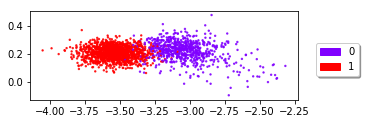

In [18]:
xs, ys = np.array(latent_z).T
plt.figure()
# plt.title("round {}: {} in latent space".format(model.step, title))
kwargs = {'alpha': 0.8}
label_list=[int(x) for x in y_train[:,0]]
classes = set(label_list)
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in label_list]
    # make room for legend
    ax = plt.subplot(111, aspect='equal')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0,0), label=class_, color=colormap[i])
              for i, class_ in enumerate(classes)]
    ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
              fancybox=True, loc='center left')

plt.scatter(xs, ys, s=2, **kwargs)



### testing data

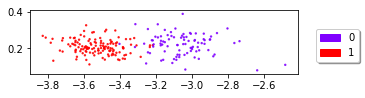

In [19]:
xs, ys = np.array(latent_z_test).T

plt.figure()
# plt.title("round {}: {} in latent space".format(model.step, title))
kwargs = {'alpha': 0.8}
label_list=[int(x) for x in y_test[:,0]]
classes = set(label_list)
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in label_list]

    # make room for legend
    ax = plt.subplot(111, aspect='equal')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0,0), label=class_, color=colormap[i])
              for i, class_ in enumerate(classes)]
    ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
              fancybox=True, loc='center left')

plt.scatter(xs, ys, s=2, **kwargs)


## Sample from p(z) and evaluate

In [23]:
new_size=50000
c=np.ones((new_size,1))
d=np.zeros((new_size,1))
z_sample_1=gaussian_mixture(new_size)
z_sample_2=gaussian_mixture(new_size)
for i in range(new_size):
    z_sample_1[i,0]=np.abs(z_sample_1[i,0])
    z_sample_2[i,0]=-1*np.abs(z_sample_2[i,0])
new_sample_N=decoder.predict([z_sample_1,c])
new_sample_F=decoder.predict([z_sample_2,d])
sess=tf.Session()
sess.run(tf.global_variables_initializer())
x_normal = x_train[0:1314]
x_mean=np.mean(x_normal,axis=0)
x_hat = autoencoder.predict([x_normal,c])
def loss(a,b):
    result = np.dot((a-b),(a-b))
    return result
def cal_var(data,mean):
    total_var = []
    for i in range(data.shape[0]):
        var = loss(data[i],mean)
        total_var.append(var)
    return total_var
new_sample_N1=new_sample_N[0:1314]
new_sample_mean=np.mean(new_sample_N1,axis=0)
print('Reconstruction:')
print('mean:',loss(x_mean,x_mean))
print('variance:',np.mean(cal_var(x_normal,x_mean)))
print('Generation:')
print('mean:',loss(new_sample_mean,x_mean))
print('variance:',np.mean(cal_var(new_sample_N1,new_sample_mean)))
np.savetxt(path + '/sample_fault1.txt',new_sample_N)



Reconstruction:
mean: 0.0
variance: 1.0974776653869511
Generation:
mean: 0.5258402606643879
variance: 0.0025428343


### sampling distribution

In [24]:
label_list=[]
for i in range(2*new_size):
    if i<new_size:
        label_list.append(1)
    else:
        label_list.append(0)

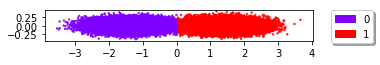

In [25]:
sample_z=np.concatenate([z_sample_1,z_sample_2],axis=0)
xs, ys = np.array(sample_z).T

plt.figure()
# plt.title("round {}: {} in latent space".format(model.step, title))
kwargs = {'alpha': 0.8}
#label_list=[int(x) for x in y_train[:,0]]
classes = set(label_list)
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in label_list]

    # make room for legend
    ax = plt.subplot(111, aspect='equal')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0,0), label=class_, color=colormap[i])
              for i, class_ in enumerate(classes)]
    ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
              fancybox=True, loc='center left')

plt.scatter(xs, ys, s=2, **kwargs)


In [26]:
x_G=new_sample_N[0:5000]
x_F=new_sample_F[0:5000]

In [27]:
g=np.ones((5000,1))
f=np.zeros((5000,1))
x_g=encoder.predict([x_G,g])
x_f=encoder.predict([x_F,f])
sample=np.concatenate([x_g,x_f],axis=0)
label_list=[]
for i in range(10000):
    if i<5000:
        label_list.append(1)
    else:
        label_list.append(0)

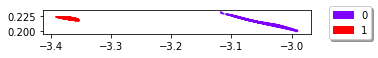

In [28]:
xs, ys = np.array(sample).T

plt.figure()
# plt.title("round {}: {} in latent space".format(model.step, title))
kwargs = {'alpha': 0.8}
#label_list=[int(x) for x in y_train[:,0]]
classes = set(label_list)
if classes:
    colormap = plt.cm.rainbow(np.linspace(0, 1, len(classes)))
    kwargs['c'] = [colormap[i] for i in label_list]

    # make room for legend
    ax = plt.subplot(111, aspect='equal')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    handles = [mpatches.Circle((0,0), label=class_, color=colormap[i])
              for i, class_ in enumerate(classes)]
    ax.legend(handles=handles, shadow=True, bbox_to_anchor=(1.05, 0.45),
              fancybox=True, loc='center left')

plt.scatter(xs, ys, s=1, **kwargs)
#ax.set_xlim([-3.5, -2])
#ax.set_ylim([0.2, 0.25])

In [30]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)

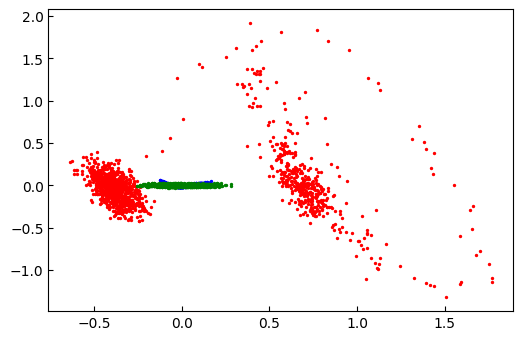

In [31]:
x_G=pca.fit_transform(x_G[0:1314])
x_F=pca.fit_transform(x_F[0:1314])
x_N=pca.fit_transform(x_normal)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'

plt.rcParams['figure.dpi'] = 100
plt.scatter(x_N[:,0],x_N[:,1],color='r',s=2)
plt.scatter(x_G[:,0],x_G[:,1],color='b',s=2)
plt.scatter(x_F[:,0],x_F[:,1],color='g',s=2)
